# Counting using SAM3

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_counting.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

from sam3.train.masks_ops import mask_iom
from utils import plot_mask, COLORS, plot_results

/checkpoint/sam3/ronghanghu/anaconda3/envs/onevision_sam3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Converting 5000 RGB samples to LAB color space...
Conversion to LAB complete.
Fitting KMeans with 128 clusters on 5000 samples...
KMeans fitting complete.


In [5]:
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

In [6]:
def run_inference_on_image(image, text_prompt, model, processor, output_prob_thresh=0.5):
    """Run inference on a single image with text prompt"""
    # Create inference state for this image
    inference_state = processor(image, instance_prompt=False)

    # Add text prompt
    processor.reset_all_prompts(inference_state)
    processor.add_prompt(inference_state, text_str=text_prompt, instance_prompt=False)

    # Run inference
    model.run_inference(inference_state)

    # Get output with the specified threshold
    output = processor.postprocess_output(inference_state, output_prob_thresh=output_prob_thresh)

    return output

def clean_mask_iom_nms(pred_scores, pred_masks, mask_threshold=0.5, score_thresh=0.5, iou_thresh=0.5):
    # Convert numpy arrays to tensors if needed
    if isinstance(pred_scores, np.ndarray):
        pred_scores = torch.from_numpy(pred_scores)
    if isinstance(pred_masks, np.ndarray):
        pred_masks = torch.from_numpy(pred_masks)

    # Handle different score tensor shapes
    if pred_scores.dim() > 1:
        scores_flat = pred_scores.squeeze() if pred_scores.shape[-1] == 1 else pred_scores.flatten()
    else:
        scores_flat = pred_scores

    keep = scores_flat >= score_thresh
    if keep.sum() < 1:
        return pred_scores, pred_masks
    maskids = torch.where(keep)[0]

    scores_subset = scores_flat[keep]
    masks_subset = pred_masks[keep].sigmoid() > mask_threshold

    N = masks_subset.size(0)

    # sort by score (desc), and compute IoM matrix on the sorted masks
    order = scores_subset.argsort(descending=True)
    masks_sorted = masks_subset[order]
    pairwise_iom = mask_iom(masks_sorted, masks_sorted)

    keep_mask = torch.zeros(N, dtype=torch.bool, device=masks_subset.device)
    suppressed = torch.zeros(N, dtype=torch.bool, device=masks_subset.device)

    for i in range(N):
        if suppressed[i]:
            continue
        keep_mask[i] = True

        # suppress all j>i that have IoM > threshold with mask i
        sup = pairwise_iom[i] > iou_thresh
        # only affect the *future* candidates
        if i + 1 < N:
            suppressed[i + 1:] |= sup[i + 1:]

    # map back to original indices
    kept_sorted_idx = torch.nonzero(keep_mask, as_tuple=False).squeeze(1)
    maskids_keep_order = order[kept_sorted_idx]
    maskids_keep = maskids[maskids_keep_order]

    new_scores, new_masks = pred_scores[maskids_keep], pred_masks[maskids_keep]

    return new_scores, new_masks

### Build the model


In [7]:
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor


sam3_root = "/home/marksm/sam3"

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
checkpoint_path = f"{sam3_root}/assets/checkpoints/checkpoint_model_only_presence_0_5.pt"

model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path)

### Counting objects (no post-processing)


found 32 object(s)


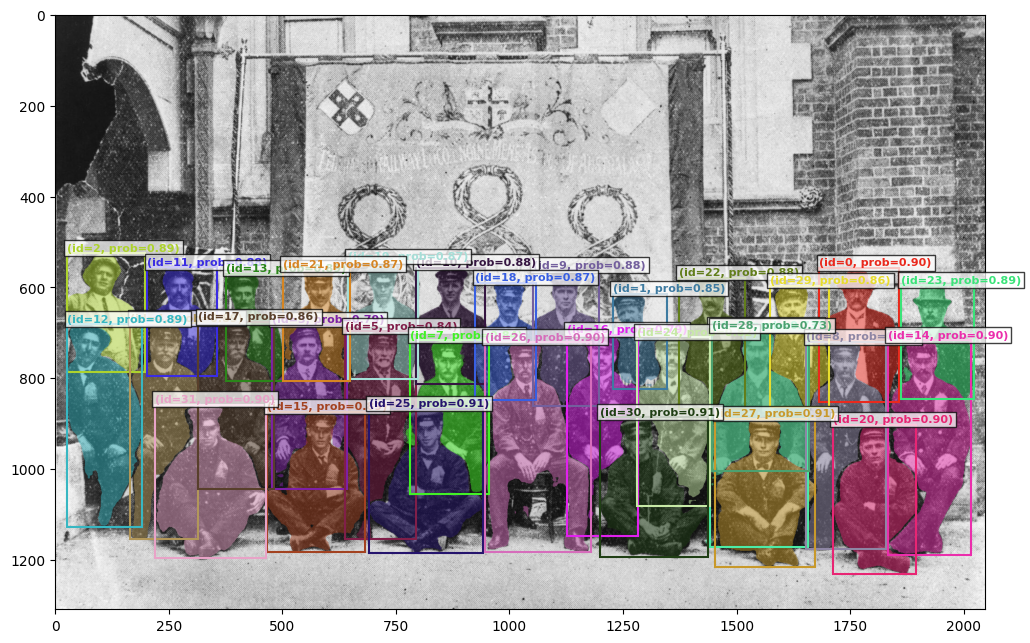

In [8]:
text_prompt = "person"
image_path = '/checkpoint/sam3/shared/sam3_release/pixmo_count_example.jpg'
image = Image.open(image_path).convert("RGB")
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)
inference_state = processor.set_text_prompt(state =inference_state, prompt=text_prompt)

plot_results(image, inference_state)

### Counting objects with IoM NMS

We observe that the model predicts 32 instances for this image, while the actual number is 31. Therefore, for the counting task, we further process the outputs using Intersection over Minimum Non-Maximum Suppression (IoM NMS). After applying this method, the number of predicted objects is reduced to 31, which matches the ground truth.

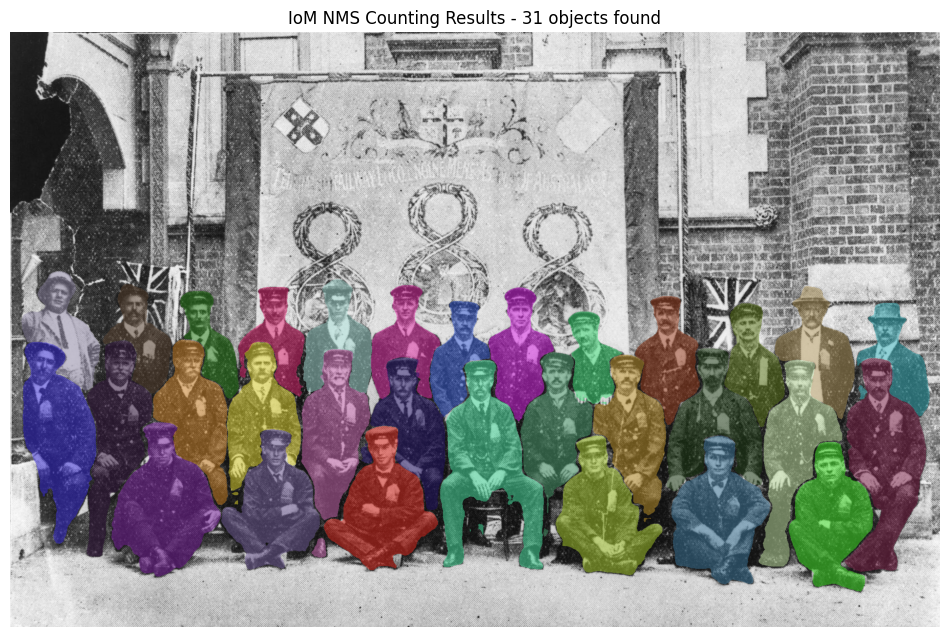

In [9]:
binary_masks = clean_mask_iom_nms(
    inference_state["scores"],
    inference_state["masks"].squeeze(1),
    mask_threshold=0.5,
    score_thresh=0.5,
    iou_thresh=0.5
)[1]
# plotting
plt.figure(figsize=(12, 8))
plt.imshow(image)
for m_idx, mask in enumerate(binary_masks):
    plot_mask(mask.cpu(), color=COLORS[m_idx % len(COLORS)])
plt.axis('off')
plt.title(f"IoM NMS Counting Results - {len(binary_masks)} objects found")
plt.show()